In [1]:
import scvelo as scv
from anndata import AnnData
import scanpy as sp

In [2]:
scv.settings.verbocity = 0 # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True
scv.set_figure_params('scvelo', transparent=False) # for beautified visualization

In [3]:
# Read in data from loom files
kul19_normal = scv.read('Data/kul19_normal.loom')
kul19_border = scv.read('Data/kul19_border.loom')
kul19_core = scv.read('Data/kul19_tumor.loom')

# Make variable names unique
kul19_normal.var_names_make_unique()
kul19_border.var_names_make_unique()
kul19_core.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
# AnnData object with 3549 normal cells
kul19_normal

AnnData object with n_obs × n_vars = 3549 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

In [5]:
# AnnData object with 3945 tumor border cells
kul19_border

AnnData object with n_obs × n_vars = 3945 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

In [6]:
# AnnData object with 4022 tumor core cells
kul19_core

AnnData object with n_obs × n_vars = 4022 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

In [30]:
# Concatenate all the objects and label by batch
kul19_all = AnnData.concatenate(kul19_normal, kul19_border, kul19_core, batch_key='batch', batch_categories=['normal', 'tumor border', 'tumor core'])
kul19_all

AnnData object with n_obs × n_vars = 11516 × 60662
    obs: 'TotalUMIs', 'batch'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

In [8]:
# The datasets are sorted by batch
kul19_all.obs

,TotalUMIs,batch
kul19_normal_AAACCTGAGTCGAGTG-normal,46313,normal
kul19_normal_AAACCTGCAGATGAGC-normal,11027,normal
kul19_normal_AAACCTGCATTAACCG-normal,8835,normal
kul19_normal_AAACCTGGTCATATCG-normal,1044,normal
kul19_normal_AAACCTGGTTGTACAC-normal,8280,normal
...,...,...
kul19_TTTGTCAGTGGCGAAT-tumor core,34311,tumor core
kul19_TTTGTCAGTTACAGAA-tumor core,11070,tumor core
kul19_TTTGTCATCAAACCAC-tumor core,3485,tumor core
kul19_TTTGTCATCACCAGGC-tumor core,1537,tumor core


In [31]:
# Preprocessing: filter and normalize, compute moments
scv.pp.filter_and_normalize(kul19_all, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(kul19_all, n_pcs=30, n_neighbors=30)

Filtered out 49368 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [32]:
# Compute RNA velocity for each cell
scv.tl.velocity(kul19_all)

computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [33]:
# Compute velocity graph
scv.tl.velocity_graph(kul19_all)

computing velocity graph
    finished (0:01:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [34]:
# Cluster with louvain
scv.tl.louvain(kul19_all, resolution=0.2)
# Embed the graph with UMAP
scv.tl.umap(kul19_all)

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


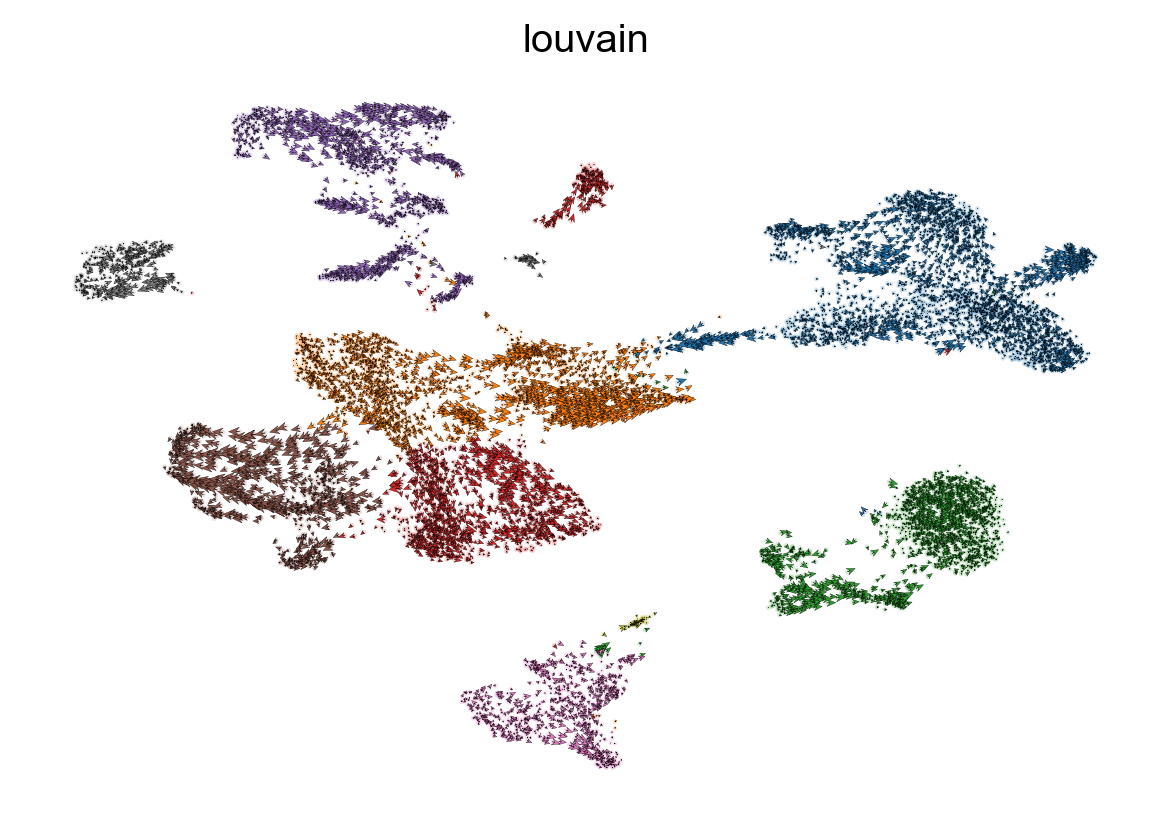

In [35]:
scv.pl.velocity_embedding(kul19_all, color='louvain', arrow_length=3, arrow_size=2, dpi=120)

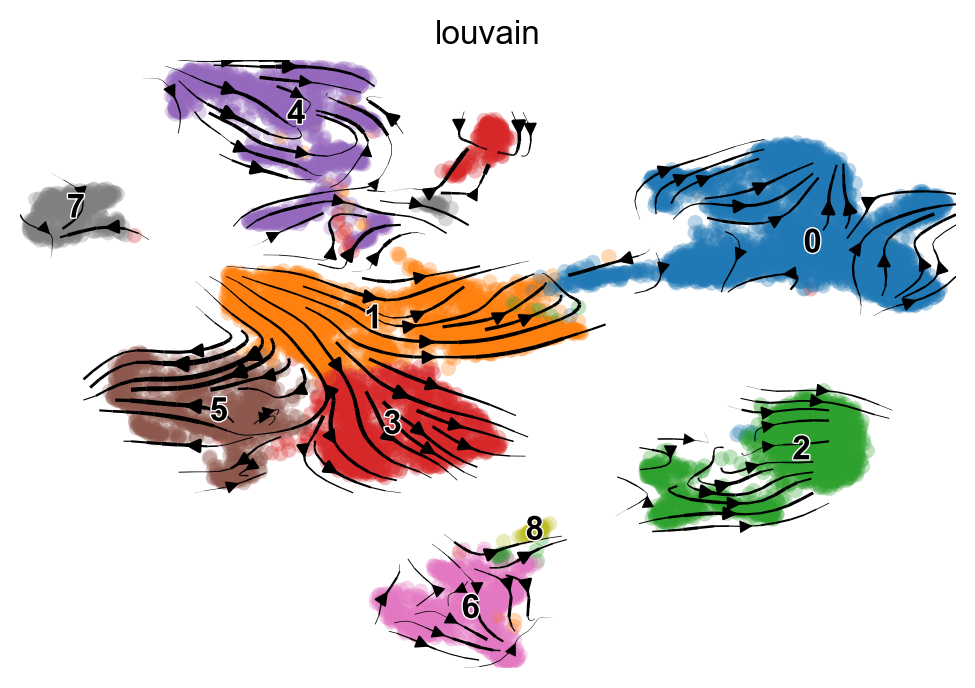

In [36]:
# Plot velocity as streamlines with cells colored by cluster
scv.pl.velocity_embedding_stream(kul19_all, color='louvain', basis='umap')

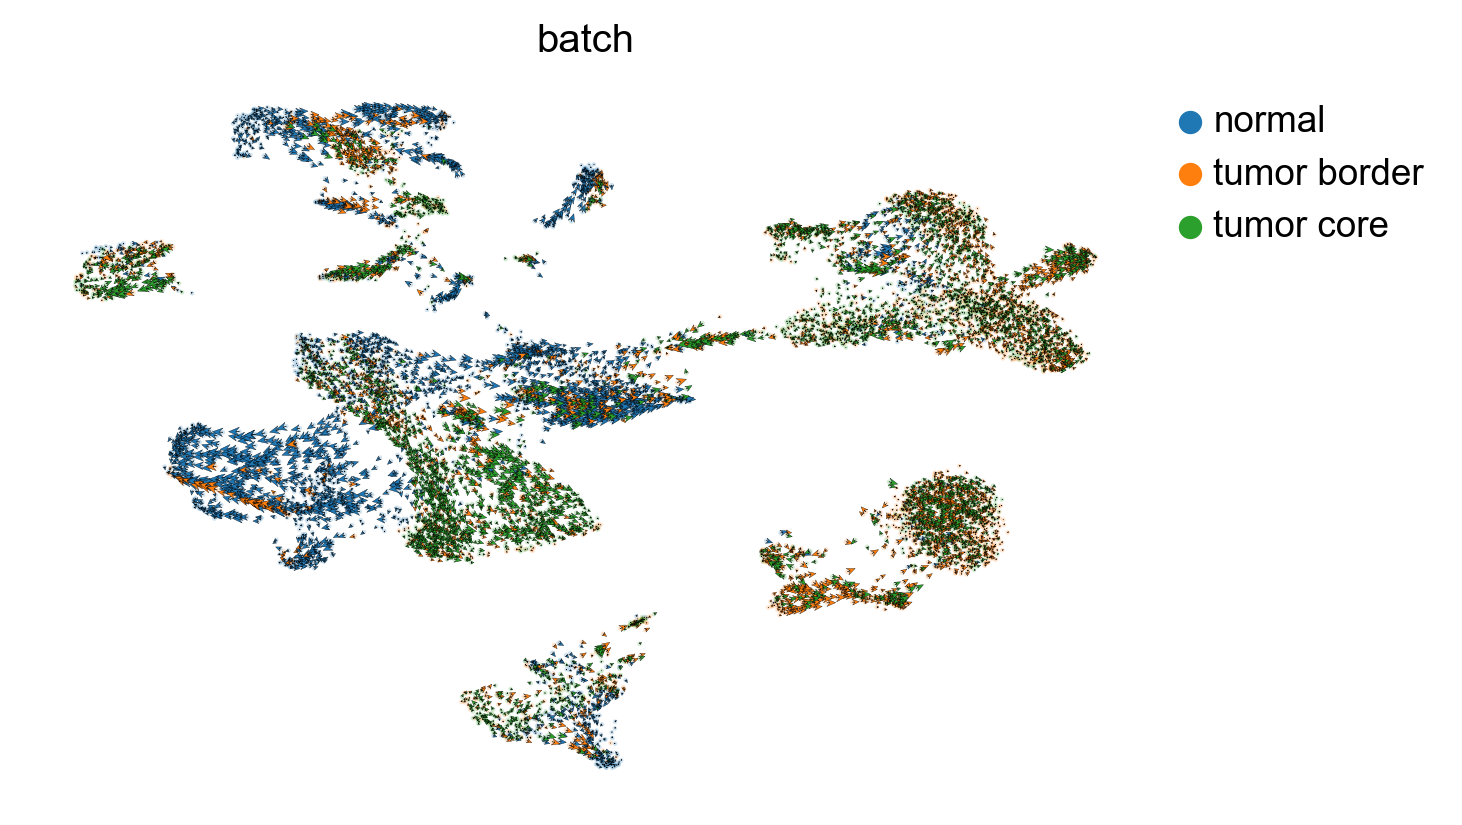

In [37]:
scv.pl.velocity_embedding(kul19_all, color='batch', legend_loc="upper right", arrow_length=3, arrow_size=2, dpi=120)

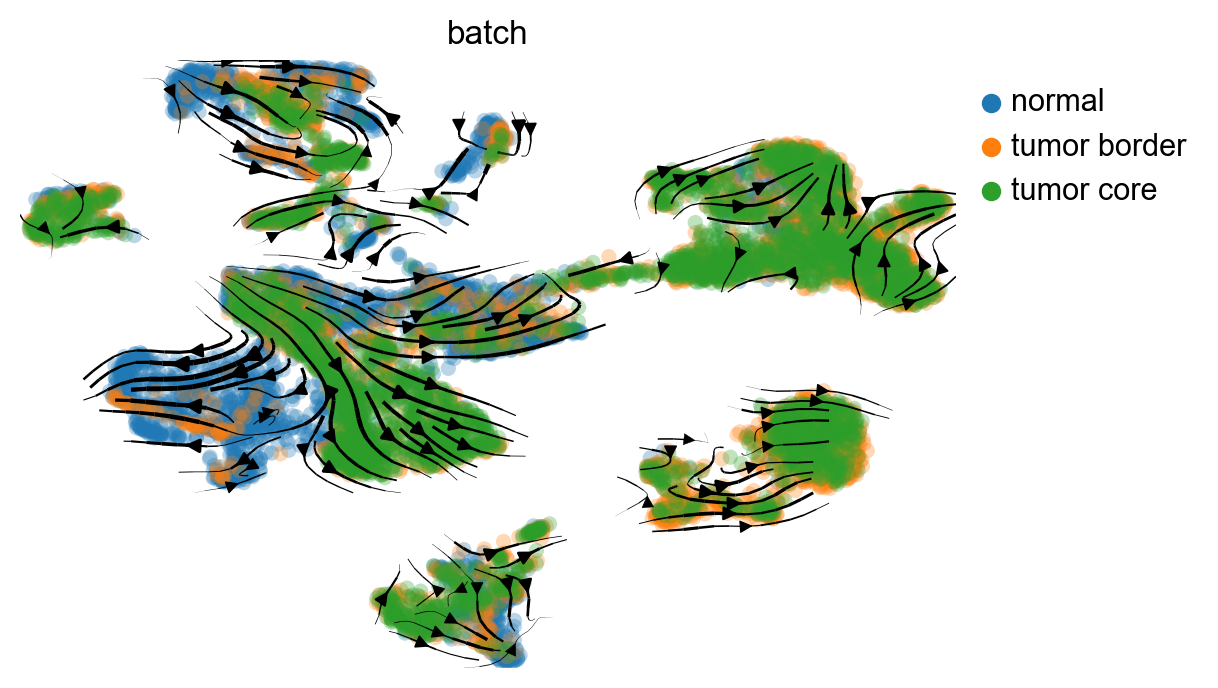

In [14]:
# Plot velocity as streamlines with cells colored by normal/tumor
scv.pl.velocity_embedding_stream(kul19_all, color='batch', basis='umap', legend_loc="upper right")

In [15]:
# Use scanpy to rank genes by expression level by cluster
sp.tl.rank_genes_groups(kul19_all, groupby='louvain')
# Store gene names in dataframe ordered by score/rank
df = scv.DataFrame(kul19_all.uns['rank_genes_groups']['names'])
df.to_csv("kul19_all_topgenes.csv", index=False) # write all genes for each cluster to csv file

... storing 'Aliases' as categorical
... storing 'CcdsID' as categorical
... storing 'CosmicID' as categorical
... storing 'HgncID' as categorical
... storing 'Location' as categorical
... storing 'LocationSortable' as categorical
... storing 'MgdID' as categorical
... storing 'MirBaseID' as categorical
... storing 'OmimID' as categorical
... storing 'PubmedID' as categorical
... storing 'RefseqID' as categorical
... storing 'RgdID' as categorical
... storing 'UcscID' as categorical
... storing 'UniprotID' as categorical
... storing 'VegaID' as categorical


In [16]:
df.head() # Print top 5 highly expressed genes in each cluster

,0,1,2,3,4,5,6,7,8
0,CD3D,MZB1,CD74,FTH1,COL6A2,PHGR1,TYROBP,IGFBP7,SRGN
1,TRAC,TENT5C,CD37,IFI27,CALD1,PIGR,CD74,IFI27,FTH1
2,B2M,ABCB9,HLA-DRB1,TXN,CST3,LGALS4,CST3,SPARCL1,TMSB4X
3,CD2,IGLL5,RPS20,PHGR1,C1S,KRT8,HLA-DRB1,ENG,ALOX5AP
4,SRGN,PIM2,MS4A1,KRT8,DCN,KRT19,FCER1G,A2M,SAMSN1


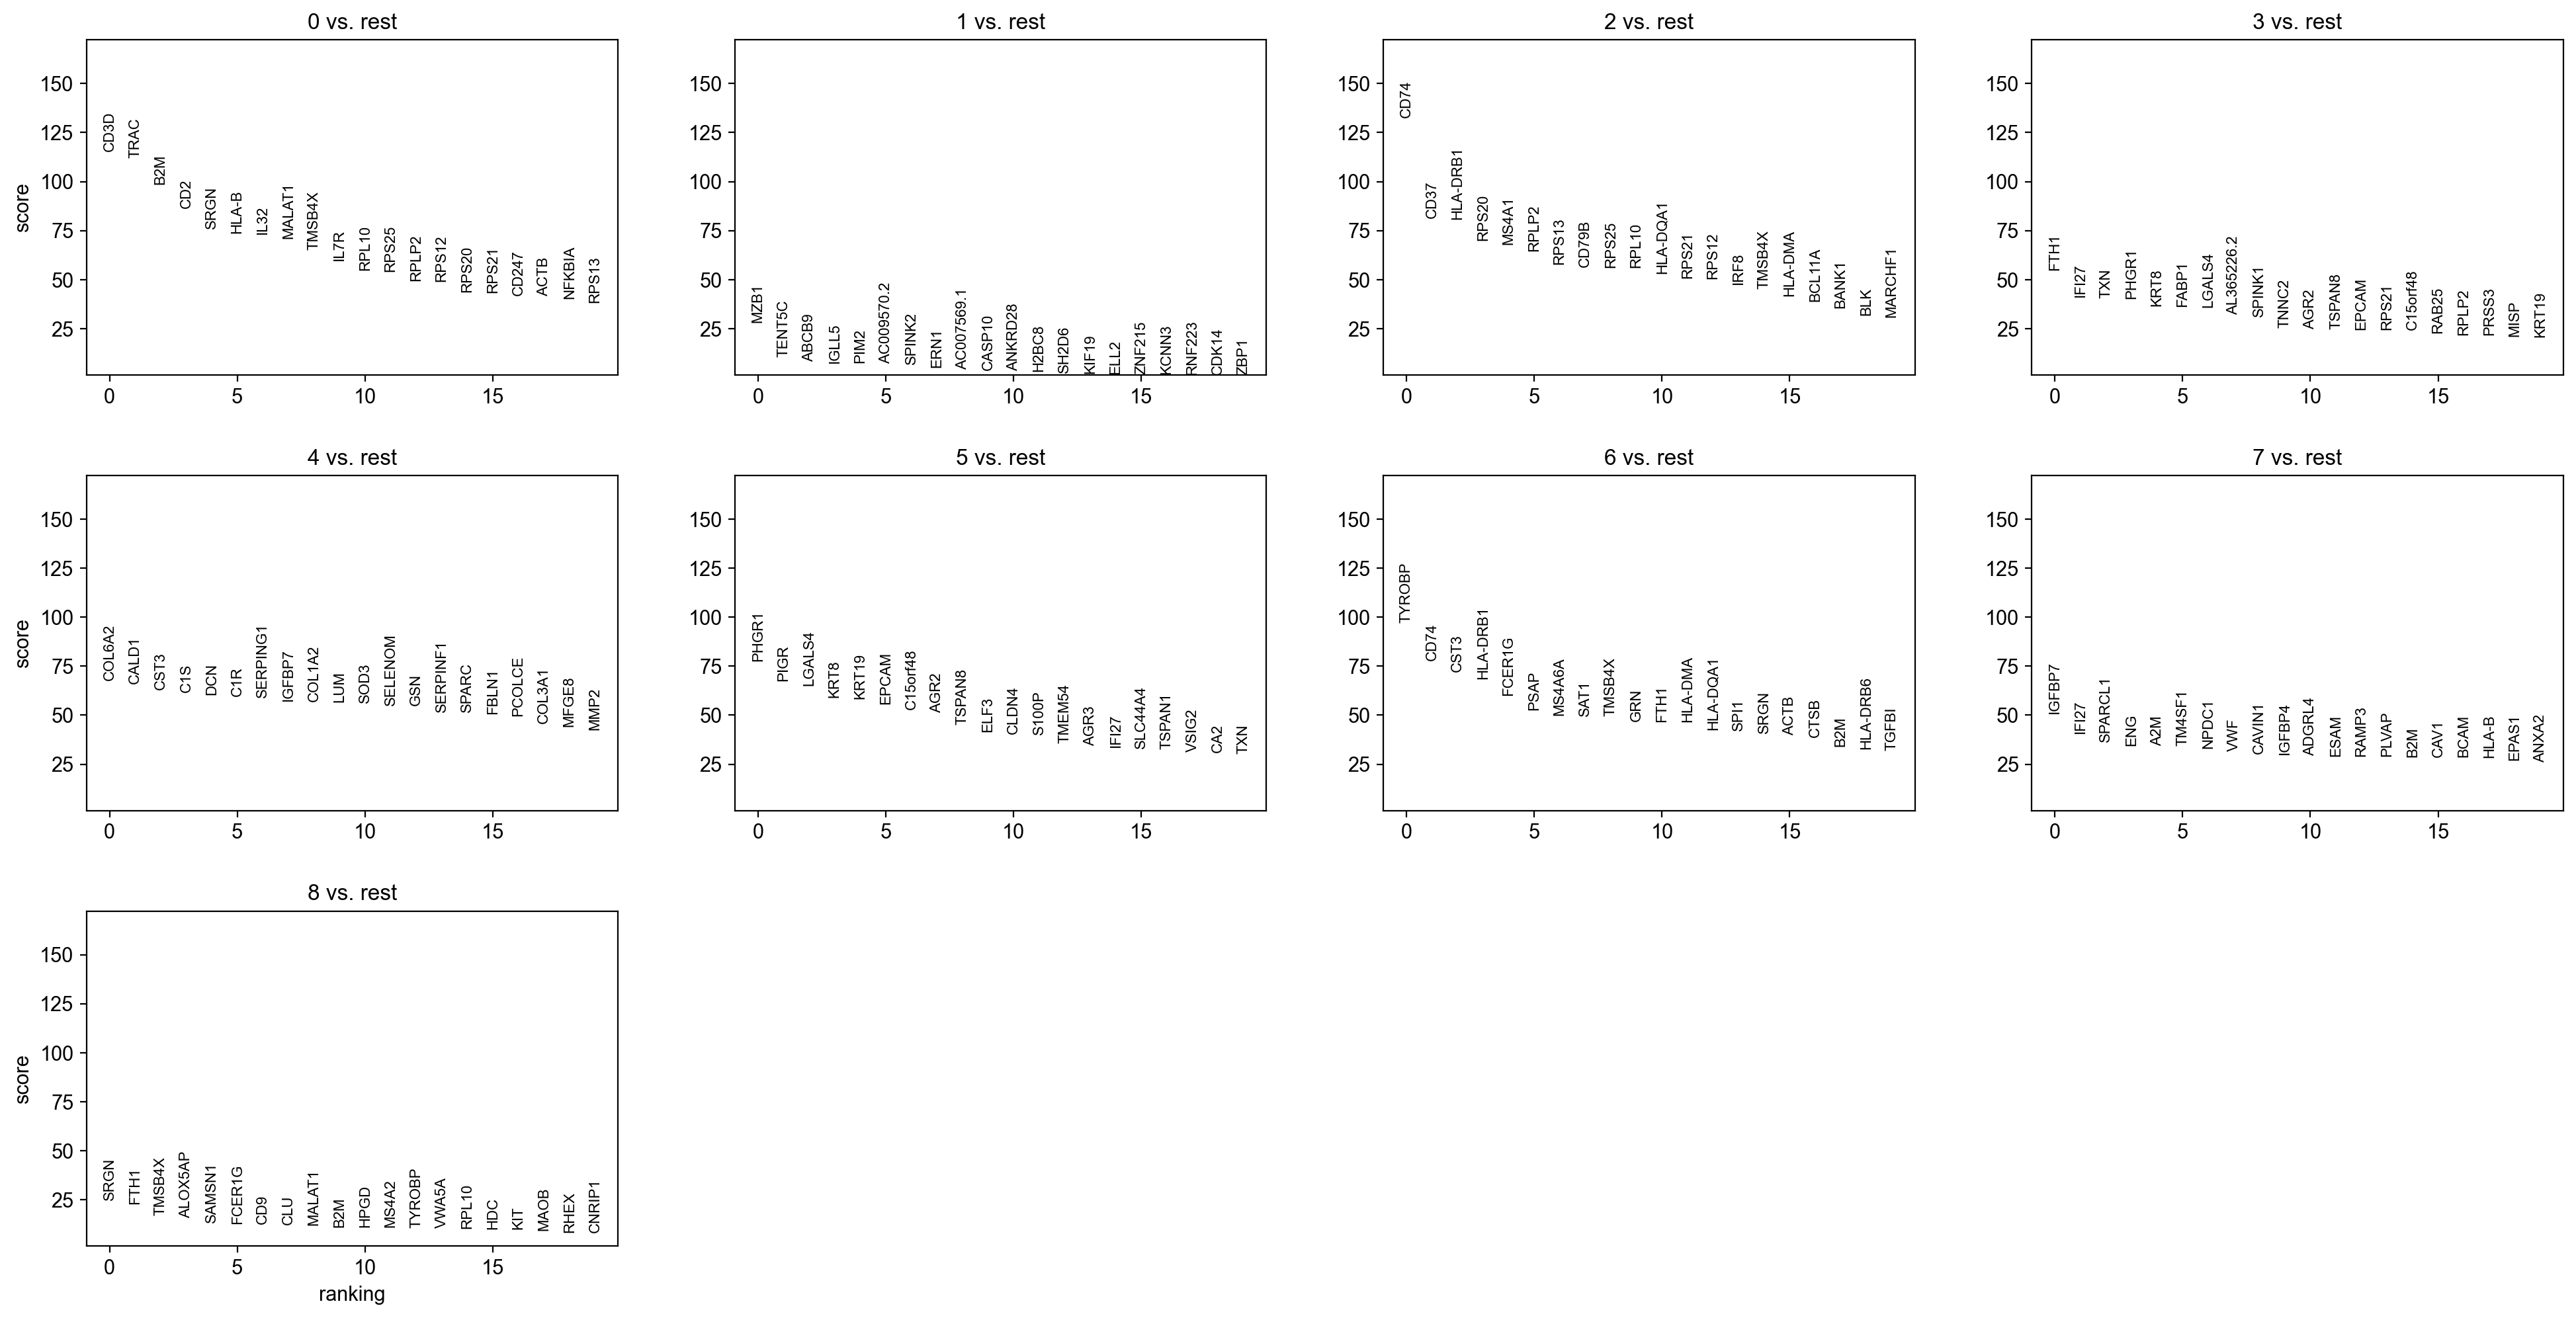

In [17]:
sp.pl.rank_genes_groups(kul19_all)

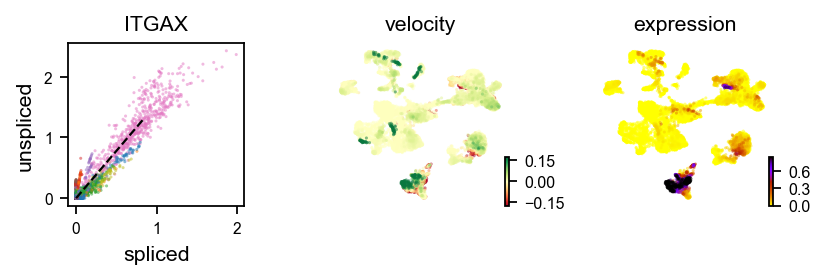

In [18]:
# Trying to figure out cluster identities
myeloid_gene_list = ['ITGAX', 'CD68', 'CD14', 'CCL3'] # good
fibroblast_gene_list = ['TAGLN', 'ACTA2', 'SPARC', 'COL14A', 'COL3A1', 'DCN']
endothelial_gene_list = ['ENG', 'PECAM1']
Tcell_gene_list = ['CD3D', 'TRAC'] # good
Bcell_gene_list = ['CD74', 'CD38', 'IGHA', 'CD20', 'CD79A']
mastcell_gene_list= ['KIT', 'TPSB2']
epithelial_gene_list= ['VIL1', 'KRT20', 'CLDN7', 'CDH1']

scv.pl.velocity(kul19_all, myeloid_gene_list, ncols=2)

In [19]:
# Dynamical model of RNA velocity
scv.tl.recover_dynamics(kul19_all)

recovering dynamics
    finished (0:28:38) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [20]:
scv.tl.velocity(kul19_all, mode='dynamical')
scv.tl.velocity_graph(kul19_all)

computing velocities
    finished (0:00:16) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [21]:
kul19_all.write('Data/kul19.h5ad')

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


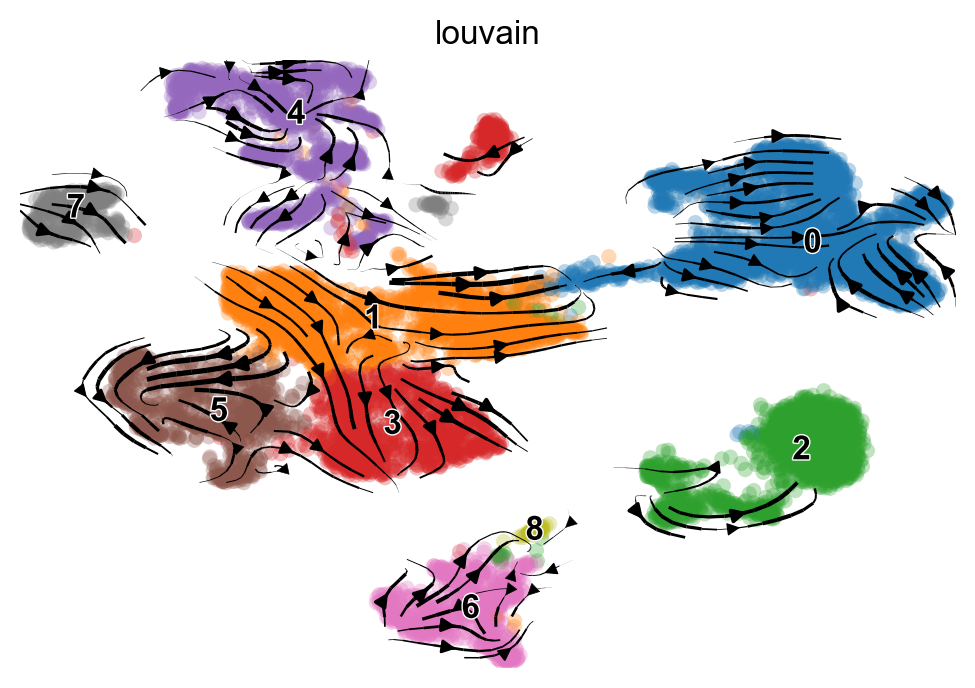

In [22]:
scv.pl.velocity_embedding_stream(kul19_all)